In [1]:
# Imports

from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.gridspec as gridspec

import Model.tools as tools
from Model.cochlea import cochlea






In [2]:
# Load Data

samplerate, data = wavfile.read('Audio/sinusoid_pulse_200_2000.wav')


# Discard single channel as we model only one ear in this case
audio = np.array(data[:, 0], dtype=float)
# Signal length in samples
nt = len(audio)

print("Sample rate of audio data: {}".format(samplerate))
print("Length of signal: {} samples".format(nt))
print("Temporal signal duration: {} seconds ({} minutes and {} seconds)"
      .format(nt/samplerate, int((nt/samplerate)//60), (nt/samplerate)%60))

Sample rate of audio data: 44100
Length of signal: 74419 samples
Temporal signal duration: 1.6875056689342403 seconds (0 minutes and 1.6875056689342403 seconds)


dB of signal=1 at reference 200: -46.020599913279625
Gain required to take level to 30dB: 76.02059991327963
prenorm dB: -66.75265031904205, norm dB: 7.448620008438912


Text(0, 0.5, 'Signal Pressure')

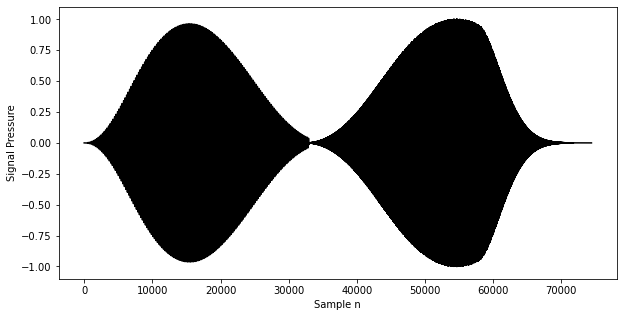

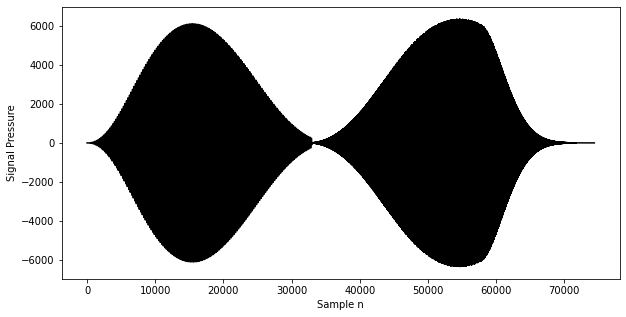

In [3]:
#Rescale signal between -1 and 1
audio = tools.rescale(audio, (-1, 1))

# Plot signal in the time domain
plt.figure(figsize=(10, 5))
plt.plot(audio, color='k')
plt.xlabel('Sample n')
plt.ylabel('Signal Pressure')


db_ref = 200

db_1 = tools.amp2db(1, db_ref)
print("dB of signal=1 at reference {}: {}".format(db_ref, db_1))

gain = 30 - tools.amp2db(1, db_ref)
print("Gain required to take level to 30dB: {}".format(gain))

audio_db = np.mean(tools.amp2db(audio, reference=db_ref))

audio_amplified = tools.dbgain(audio, gain)
audio_amplified_db = np.mean(tools.amp2db(audio_amplified, reference=db_ref))

print("prenorm dB: {}, norm dB: {}".format(audio_db, audio_amplified_db))

audio = audio_amplified

# Plot signal in the time domain
plt.figure(figsize=(10, 5))
plt.plot(audio, color='k')
plt.xlabel('Sample n')
plt.ylabel('Signal Pressure')

Text(0, 0.5, 'Magnitude')

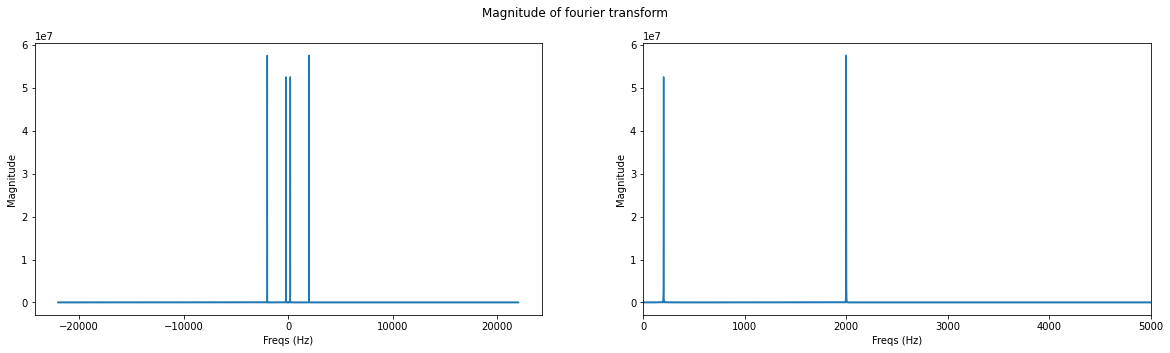

In [4]:
# # Plot signal in the fourier domain
audio_fft = np.fft.fft(audio)
audio_fft_freqs = np.fft.fftfreq(nt, 1/samplerate)

plt.figure(figsize=(20, 5))
plt.suptitle('Magnitude of fourier transform')
plt.subplot(1, 2, 1)
plt.plot(audio_fft_freqs, np.abs(audio_fft))
plt.xlabel('Freqs (Hz)')
plt.ylabel('Magnitude')


plt.subplot(1, 2, 2)
plt.plot(audio_fft_freqs, np.abs(audio_fft))
plt.xlim(0, 5000)
plt.xlabel('Freqs (Hz)')
plt.ylabel('Magnitude')

In [5]:
# Initialise Model

model = cochlea()
model.set_input(audio, samplerate)

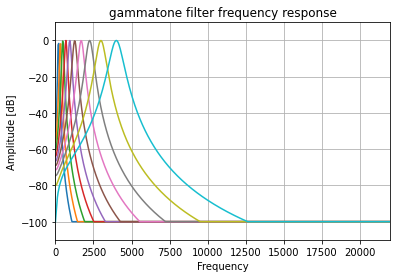

In [6]:
# Generate gammatone basilar membrane filterbank
flims = [200, 4000]
nfilt = 10

#possible basilar membrane filter types:
# gammatone
# transp
model.set_BM('gammatone', flims, nfilt)

#Plot filters
model.visualise_filterbank()

In [7]:
# Filter signal using each band in filterbank (basilar membrane stage 1)
model.filter_bm()

In [8]:
# Filter each band using Bernstein 1999 (IHC stage 2)
model.set_ihc()
model.ihc['filter'].add_halfwave()
model.ihc['filter'].add_hilbert()

model.filter_ihc()

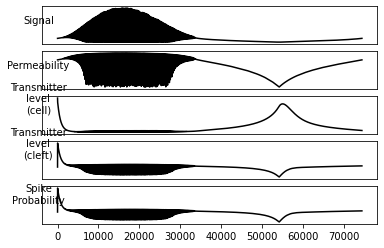

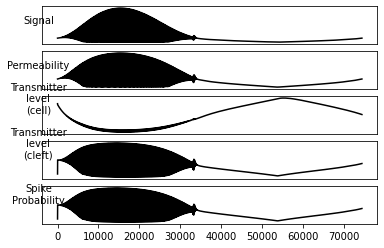

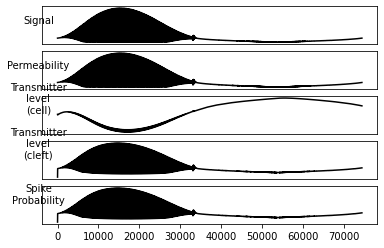

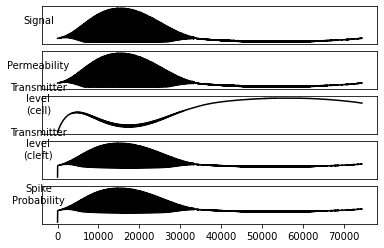

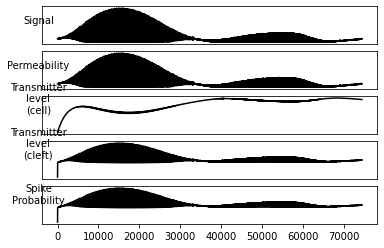

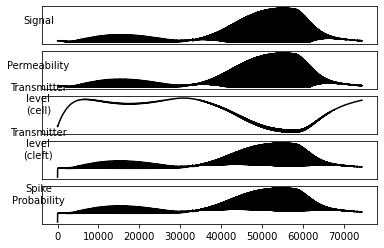

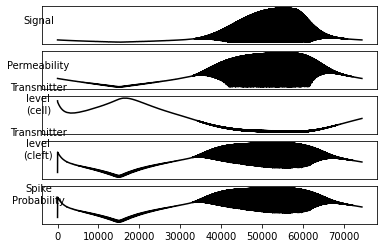

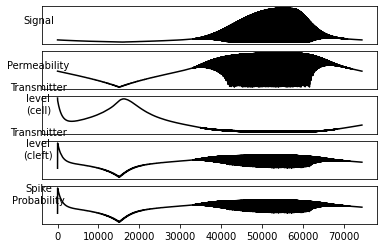

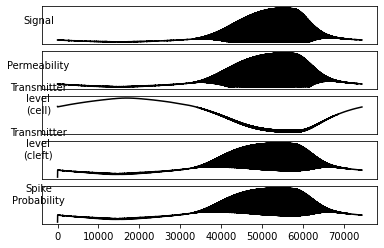

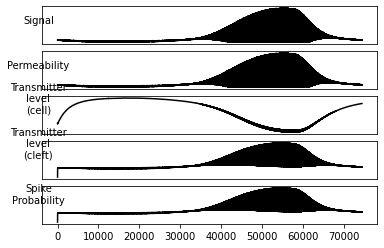

In [9]:
model.set_an()
model.filter_an()

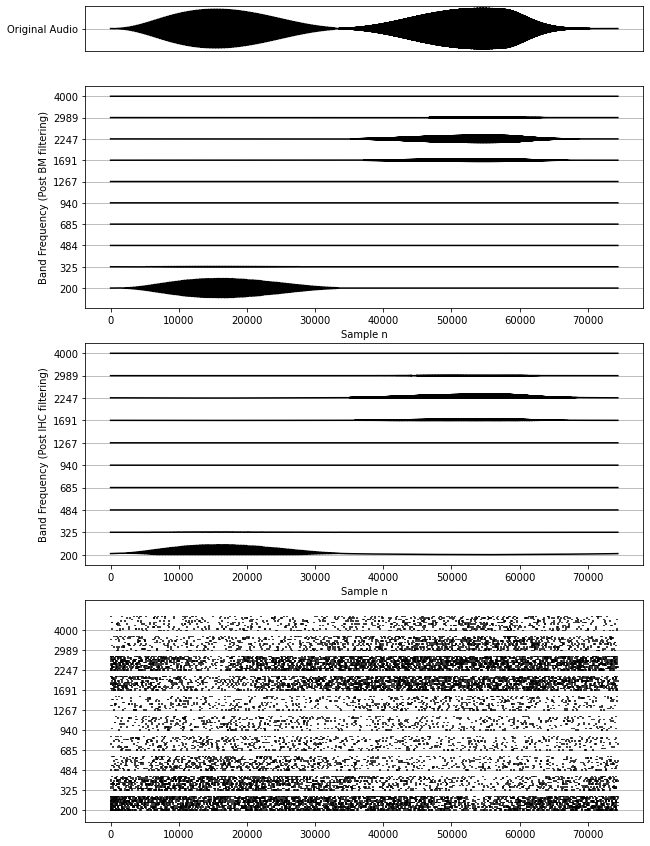

In [10]:
plt.figure(figsize=(10, 15))
gs = gridspec.GridSpec(4, 1,height_ratios=[2, nfilt,nfilt, nfilt])

ax_audio = plt.subplot(gs[0])
ax_audio.plot(audio, color='k')
ax_audio.set_xticks([])
ax_audio.set_yticks([0])
ax_audio.set_yticklabels(['Original Audio'])
plt.grid(which='both', axis='y')    

ax_bm = plt.subplot(gs[1])
model.plot_bm(ax_bm)
ax_audio.set_xticks([])
plt.grid(which='both', axis='y')    

ax_ihc = plt.subplot(gs[2])
model.plot_ihc(ax_ihc)
plt.grid(which='both', axis='y')   

ax_raster = plt.subplot(gs[3])
model.plot_raster(ax_raster, padding=3)
plt.grid(which='both', axis='y')   


C:\Users\richa\AppData\Local\Temp\ipykernel_12200\3212318249.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_psth.set_xticklabels(psth_locs, rotation = 45)
C:\Users\richa\AppData\Local\Temp\ipykernel_12200\3212318249.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_psth.set_xticklabels(psth_locs, rotation = 45)
C:\Users\richa\AppData\Local\Temp\ipykernel_12200\3212318249.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_psth.set_xticklabels(psth_locs, rotation = 45)
C:\Users\richa\AppData\Local\Temp\ipykernel_12200\3212318249.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_psth.set_xticklabels(psth_locs, rotation = 45)
C:\Users\richa\AppData\Local\Temp\ipykernel_12200\3212318249.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_psth.set_xticklabels(psth_locs, rotation = 45)
C:\Users\richa\AppData\Lo

Firing rate minima and maxima: 25.0, 329.0


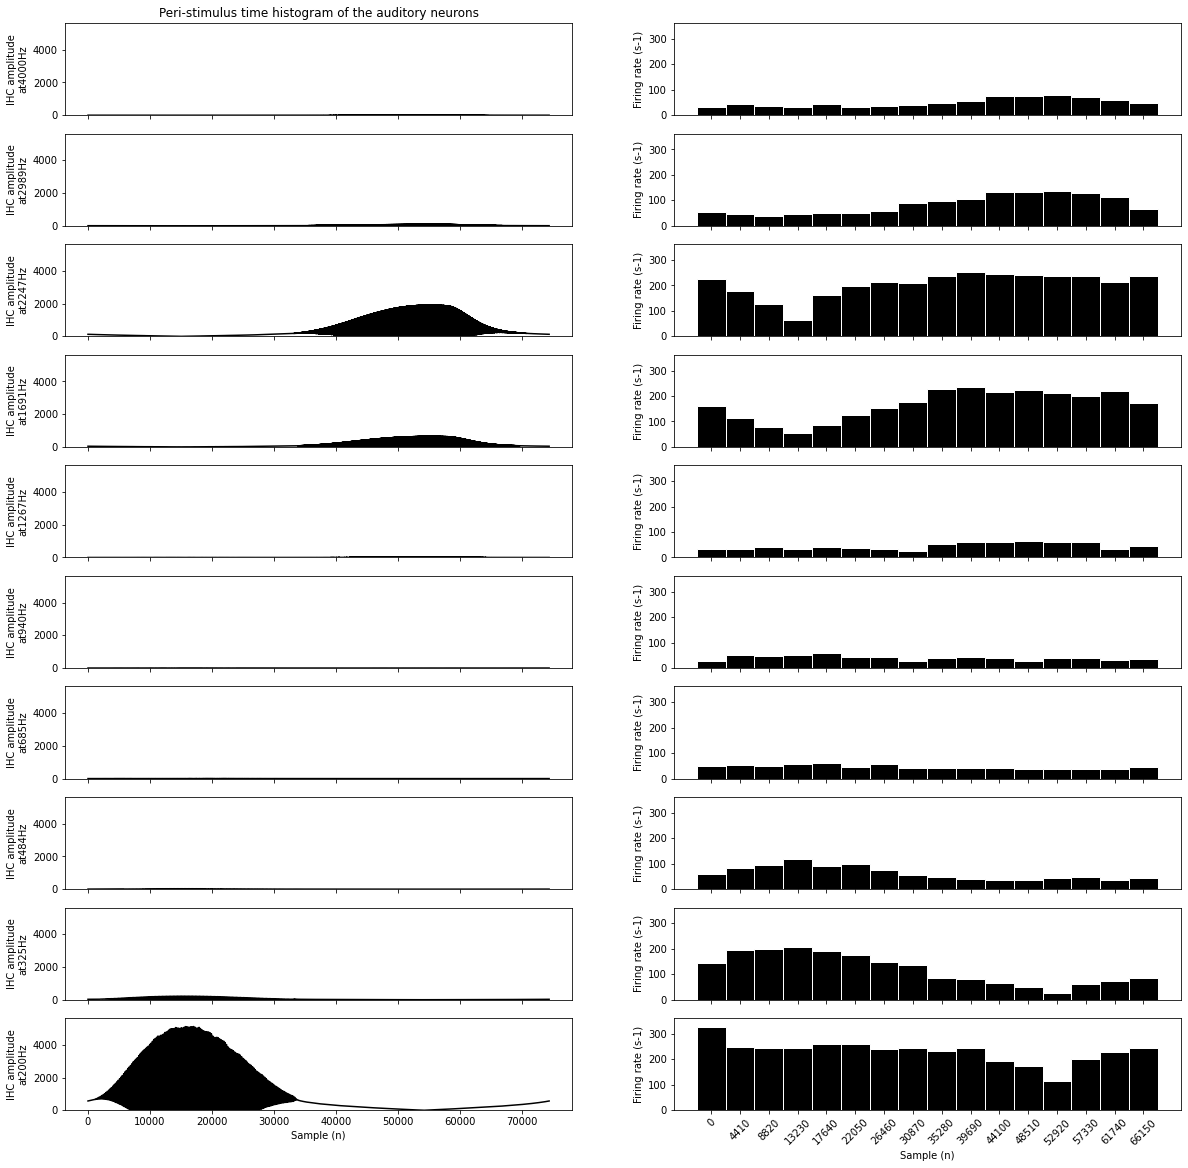

In [11]:
psths, psth_locs = model.get_psth()
signals_ihc = model.get_signals_ihc()

plt.figure(figsize=(20, 20))
axs_psth = []
axs_ihc = []

counter = 0
for i, (f, psth) in enumerate(psths.items()):
    ax_psth = plt.subplot(nfilt, 2, nfilt*2-counter)
    axs_psth.append(ax_psth)
    counter = counter+1
    plt.bar(psth_locs, psth, width=1, color='k', edgecolor="w") 
    plt.ylabel("Firing rate (s-1)")
    ax_psth.set_xticklabels(psth_locs, rotation = 45)

    
    ax_ihc = plt.subplot(nfilt, 2, nfilt*2-counter)
    axs_ihc.append(ax_ihc)
    counter = counter+1
    signal_ihc = signals_ihc[f]
    plt.plot(signal_ihc, color='k')
    plt.ylabel("IHC amplitude\nat" + f + "Hz")
    
    
    
    
for ax in axs_psth[1:]:
    ax.xaxis.set_tick_params(labelbottom=False)
for ax in axs_ihc[1:]:
    ax.xaxis.set_tick_params(labelbottom=False)
    
axs_psth[0].set_xlabel('Sample (n)')
axs_ihc[0].set_xlabel('Sample (n)')

firingrate_max = max([max(psth) for psth in psths.values()])
firingrate_min = min([min(psth) for psth in psths.values()])
signal_max = max([max(signal) for signal in signals_ihc.values()])
signal_min = min([min(signal) for signal in signals_ihc.values()])

for ax in axs_psth:
    ax.set_ylim([0, firingrate_max*1.1])
    
for ax in axs_ihc:
    ax.set_ylim([0, signal_max*1.1])
    
plt.title('Peri-stimulus time histogram of the auditory neurons')

print("Firing rate minima and maxima: {}, {}".format(firingrate_min, firingrate_max))